In [1]:
import nltk
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# Download the Brown corpus and the universal tagset
nltk.download("brown")
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /home/cs240lab/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/cs240lab/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
from nltk.corpus import brown

# Get the tagged sentences from the Brown corpus
tagged_sentences = brown.tagged_sents(tagset="universal")
tagged_sentences = list(tagged_sentences)


In [3]:
folds = []

num_sentences = len(tagged_sentences)

for i in range(5):
    folds.append(tagged_sentences[i * int(num_sentences / 5) : (i + 1) * int(num_sentences / 5)])

In [4]:
"""---------------------GLOBAL VARIABLES------------------------"""
states = set()
words = set()
for sentence in tagged_sentences:
    for word in sentence:
        states.add(word[1])
        words.add(word[0].lower())


state_index_mapping = {}
word_index_mapping = {}


state_index_mapping["START"] = 0
word_index_mapping[""] = 0

i = 1
for state in states:
    state_index_mapping[state] = i
    i += 1
state_index_mapping["END"] = i
    
i = 1
for word in words:
    word_index_mapping[word] = i
    i += 1
    
n_states = len(states) + 2
n_words = len(words) + 1

inverse_state_mapping = {}
for key, value in state_index_mapping.items():
    inverse_state_mapping[value] = key
    
print(state_index_mapping)
"""---------------------FUNCTIONS------------------------"""


def make_set(folds, fold_num):
    train_sentences = []
    test_sentences = []
    for i in range(5):
        if ( i != fold_num ):
            train_sentences.extend(folds[i])
        else:
            test_sentences.extend(folds[i])
    
    return train_sentences, test_sentences

def get_matrices(train_sentences):
    
    transition_matrix = np.ones((n_states, n_states))
    emission_matrix = np.ones((n_states, n_words))

    for sentence in train_sentences:
        transition_matrix[0][state_index_mapping[sentence[0][1]]] += 1 # for the start
        emission_matrix[0][0] += 1
        for i in range(len(sentence) - 1):
            cur_word = sentence[i]
            next_word = sentence[i + 1]
            row = state_index_mapping[cur_word[1]]
            col = state_index_mapping[next_word[1]]
            emission_matrix[row][word_index_mapping[cur_word[0].lower()]] += 1

            transition_matrix[row][col] += 1
        emission_matrix[col][word_index_mapping[next_word[0].lower()]] += 1
        end_state = state_index_mapping["END"]
        epsilon = word_index_mapping[""]
        transition_matrix[col][end_state] += 1
        transition_matrix[end_state][epsilon] += 1
    

    transition_matrix = transition_matrix / np.sum(transition_matrix, axis = 1)
    emission_matrix = emission_matrix / np.sum(emission_matrix, axis = 1, keepdims=True)

    return transition_matrix, emission_matrix



{'START': 0, '.': 1, 'NUM': 2, 'PRT': 3, 'X': 4, 'VERB': 5, 'DET': 6, 'NOUN': 7, 'ADP': 8, 'CONJ': 9, 'ADV': 10, 'PRON': 11, 'ADJ': 12, 'END': 13}


In [5]:
def Viterbi(output_sequence: list, transition_matrix: np.ndarray, emission_matrix: np.ndarray):
    N = transition_matrix.shape[0]

    output_sequence.insert(0, "")
    T = len(output_sequence) + 1

    SEQSCORE = np.zeros((N, T))
    BACKPTR = np.zeros((N, T))
    SEQSCORE.fill(-np.inf)
    C = np.zeros(T)
    SEQSCORE[0, 0] = 0

    for t in range(1, T):
        for i in range(N):
            max_j = 0
            max_val = -np.inf
            for j in range(N):
                temp = SEQSCORE[j, t - 1] + transition_matrix[j][i] + emission_matrix[j][word_index_mapping[output_sequence[t - 1].lower()]]
                if max_val < temp: 
                    max_j = j
                    max_val = temp
            BACKPTR[i, t] = max_j
            SEQSCORE[i, t] = max_val

    C[T-1] = np.argmax(SEQSCORE[:, T - 1])
    for i in range(T-2, -1, -1):
        C[i] = BACKPTR[int(C[i + 1]), i + 1]
    return C

In [6]:
total_predicted = []
total_actual = []

for fold_num in range(5):
    print(fold_num)
    train_sent, test_sent = make_set(folds, fold_num)
    transition_matrix, emission_matrix = get_matrices(train_sent)

    transition_matrix = np.log(transition_matrix)
    emission_matrix = np.log(emission_matrix)
    
    for i in range(len(test_sent)):
        predicted_classes = Viterbi(list(np.array(test_sent[i])[:, 0]), transition_matrix, emission_matrix)
        total_predicted.extend(predicted_classes[1:-1])
        
        actual = []
        for j in range(len(test_sent[i])):
            actual.append(state_index_mapping[test_sent[i][j][1]])
        total_actual.extend(actual)

print("Accuracy is", accuracy_score(total_actual, total_predicted))

print("Classification Report")

print(classification_report(total_actual, total_predicted, target_names=list(state_index_mapping.keys())))

0
1
2
3
4
Accuracy is 0.9231332975080779
Classification Report


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       START       0.00      0.00      0.00         0
           .       0.97      1.00      0.99    147565
         NUM       0.99      0.76      0.86     14874
         PRT       0.90      0.84      0.87     29829
           X       0.53      0.18      0.27      1386
        VERB       0.96      0.90      0.93    182750
         DET       0.91      0.99      0.95    137019
        NOUN       0.94      0.88      0.91    275558
         ADP       0.91      0.97      0.94    144766
        CONJ       0.98      0.99      0.99     38151
         ADV       0.88      0.86      0.87     56239
        PRON       0.86      0.95      0.91     49334
         ADJ       0.86      0.86      0.86     83721
         END       0.00      0.00      0.00         0

    accuracy                           0.92   1161192
   macro avg       0.76      0.73      0.74   1161192
weighted avg       0.93      0.92      0.93   1161192



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


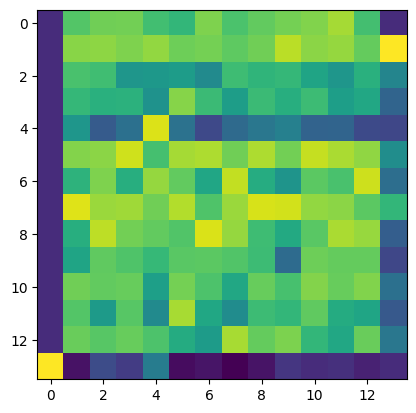

In [7]:
full_transition_matrix, full_emission_matrix = get_matrices(tagged_sentences)
full_emission_matrix = np.log(full_emission_matrix)
full_transition_matrix = np.log(full_transition_matrix)
import matplotlib.pyplot as plt

plt.imshow(full_transition_matrix, cmap='viridis')

In [8]:
def get_tags(labels):
    tags = []
    for i in range(len(labels)):
        tags.append(inverse_state_mapping[labels[i]])
    return tags

def predict_tags(output_sequence: list, transition_matrix: np.ndarray, emission_matrix: np.ndarray):
    classes = Viterbi(output_sequence, transition_matrix, emission_matrix)
    final_classes = classes[1: -1]

    return get_tags(final_classes)

sentence = "The lazy red apple hopped over the active donkey".split() # Fill the "sentence" variable with the sentence you want to find the POS tags
print(predict_tags(sentence, full_transition_matrix, full_emission_matrix))

['DET', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN']
